In [24]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import requests
import glob
import json
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from dataclasses import dataclass, field
from sparrow import Protein
from collections import defaultdict
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP

## Input staging function Declarations

### Tripeptide Column Generation

In [2]:
def getTripeptideColumn(df, ordered_list, disordered_list):
    '''
    Input: Dataframe containing the Columns: ID with PDB IDs, Residue Number containing position in the peptide,
           amino_acid containing the AA at that position and Disordered containing a binary value 

           List of Ordered statistically significant tripeptide motifs

           List of Disordered statistically significant tripeptide motifs

    Output: Input dataframe with a tripeptide significance column appended containing an array with binary values
            indicating whether all possible tripeptides containing that positions amino acid statistical significance

    Function: This function runs along every amino acid in a peptide and checks all tripeptides that contain it for 
              statistical significance against the lists provided 
    '''
    Significance_df = pd.DataFrame()
    # Iterate over rows in the data frame
    uniprot_ids = sorted(set(df.loc[:,'ID']))
    for uniprot_id in uniprot_ids:
        uniprot_df = df[df['ID'] == uniprot_id]
        residue_numbers = uniprot_df['residue_number'].values
        for i in uniprot_df.index:
            tripeptides = list()
            if uniprot_df.loc[i, 'Disordered'] == 1:
                tripeptide_list = disordered_list

            elif uniprot_df.loc[i, 'Disordered'] == 0:
                tripeptide_list = ordered_list

            else:
                tripeptide_list = ordered_list
    # First Amino Acid
            if i == uniprot_df.index[0]:
                    """
                    [A]-T-C-Y-K-P-Y-L
                         0  1 2 3 4 5 6 7
                    
                    Should only return ATC
                    
                    """
                    tripeptide = uniprot_df.loc[i:i+2,'amino_acid'].values
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at position {i} in {uniprot_df.loc[i, 'ID']}\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.at[i, 'tripeptide_significance'] = [0,0,1]

                        else:
                            uniprot_df.at[i, 'tripeptide_significance'] = [0,0,0]

    # Second Amino Acid
            elif i == uniprot_df.index[1]:
                    """ 
                    A-[T]-C-Y-K-P-Y-L
                         0  1  2 3 4 5 6 7
                    
                    Should only return ATC and TCY
                    
                    """
                    
                    tripeptide = uniprot_df.loc[i-1:i+1,'amino_acid'].values
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at position {i} in {uniprot_df.loc[i, 'ID']}\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.at[i, 'tripeptide_significance'] = [0,1]

                        else:
                            uniprot_df.at[i, 'tripeptide_significance'] = [0,0]
                    
                    tripeptide = uniprot_df.loc[i:i+2,'amino_acid'].values
                    
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at position {i} in {uniprot_df.loc[i, 'ID']}\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(1)

                        else:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(0)

    # Last Amino Acid
            elif i == uniprot_df.index[-1]:
                    
                    """  A-T-C-Y-K-P-Y-[L]
                         0 1 2 3 4-3-2 -1
                         
                    Should only return PYL
                    
                    """
                    tripeptide = uniprot_df.loc[i-2:i,'amino_acid'].values
                    
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at position {i} in {uniprot_df.loc[i, 'ID']}\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.at[i, 'tripeptide_significance'] = [1,0,0]

                        else:
                            uniprot_df.at[i, 'tripeptide_significance'] = [0,0,0]

    # Second Last Amino Acid
            elif i == uniprot_df.index[-2]:
                    
                    """  A-T-C-Y-K-P-[Y]-L
                         0 1 2 3 4-3 -2 -1
                         
                    Should only return PYL and KPY
                    
                    """
                    tripeptide = uniprot_df.loc[i-2:i,'amino_acid'].values
                    
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at position {i} in {uniprot_df.loc[i, 'ID']}\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.loc[i, 'tripeptide_significance'] = [1]

                        else:
                            uniprot_df.loc[i, 'tripeptide_significance'] = [0]
                    
                    tripeptide = uniprot_df.loc[i-1:i+1,'amino_acid'].values
                    
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at position {i} in {uniprot_df.loc[i, 'ID']}\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(1)
                            uniprot_df.loc[i, 'tripeptide_significance'].append(0)
                            

                        else:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(0)
                            uniprot_df.loc[i, 'tripeptide_significance'].append(0)
    # All Other AAs
            else: 
                    
                    tripeptide = uniprot_df.loc[i-2:i,'amino_acid'].values
                    
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at position {i} in {uniprot_df.loc[i, 'ID']}\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.loc[i, 'tripeptide_significance'] = [1]

                        else:
                            uniprot_df.loc[i, 'tripeptide_significance'] = [0]
                        
                    tripeptide = uniprot_df.loc[i-1:i+1,'amino_acid'].values
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at position {i} in {uniprot_df.loc[i, 'ID']}\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(1)

                        else:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(0)
                        
                    tripeptide = uniprot_df.loc[i:i+2,'amino_acid'].values
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at position {i} in {uniprot_df.loc[i, 'ID']}\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(1)

                        else:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(0)
        
        Significance_df = pd.concat([Significance_df ,uniprot_df], ignore_index=True)

    return(Significance_df)
                        

### Amino Acid Vector Generation

In [3]:
def getAA_column(df):
    '''
    Input: Dataframe containing the Columns: ID with PDB IDs, Residue Number containing position in the peptide,
           amino_acid containing the AA at that position 

    Output: Input Dataframe with column containing a vector representing that rows amino acid in one hot encoding

    Function: Take all rows amino acid a generate a vector representing that amino acid in one hot encoding 
    '''

    vectorised_df = pd.DataFrame()
    # Iterate over rows in the data frame
    uniprot_ids = sorted(set(df.loc[:,'ID']))
    for uniprot_id in uniprot_ids:
        uniprot_df = df[df['ID'] == uniprot_id]
        residue_numbers = uniprot_df['residue_number'].values
        for i in uniprot_df.index:
    # Positively Charged AAs
    # Arginine - Pos 1
            if uniprot_df.loc[i, 'amino_acid'] == 'R':
                i_list = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Histidine - Pos 2
            elif uniprot_df.loc[i, 'amino_acid'] == 'H':
                i_list = [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector
                
    # Lysine - Pos 3
            elif uniprot_df.loc[i, 'amino_acid'] == 'K':
                i_list = [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Negatively Charged AAs
    # Aspartic Acid - Pos 4
            elif uniprot_df.loc[i, 'amino_acid'] == 'D':
                i_list = [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Glutamic Acid - Pos 5
            elif uniprot_df.loc[i, 'amino_acid'] == 'E':
                i_list = [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Polar Uncharged AAs
    # Serine - Pos 6
            elif uniprot_df.loc[i, 'amino_acid'] == 'S':
                i_list = [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Threonine - Pos 7 
            elif uniprot_df.loc[i, 'amino_acid'] == 'T':
                i_list = [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Asparagine  - Pos 8 
            elif uniprot_df.loc[i, 'amino_acid'] == 'N':
                i_list = [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Glutamine - Pos 9 
            elif uniprot_df.loc[i, 'amino_acid'] == 'Q':
                i_list = [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Special cases - come back to this
    # Glycine - Pos 10
            elif uniprot_df.loc[i, 'amino_acid'] == 'G':
                i_list = [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Proline - Pos 11
            elif uniprot_df.loc[i, 'amino_acid'] == 'P':
                i_list = [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Cysteine - Pos 12
            elif uniprot_df.loc[i, 'amino_acid'] == 'C':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Hydrophobic AAs
    # Alanine - Pos 13
            elif uniprot_df.loc[i, 'amino_acid'] == 'A':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Valine - Pos 14
            elif uniprot_df.loc[i, 'amino_acid'] == 'V':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Isoleucine - Pos 15
            elif uniprot_df.loc[i, 'amino_acid'] == 'I':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Leucine - Pos 16
            elif uniprot_df.loc[i, 'amino_acid'] == 'L':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Methionine - Pos 17
            elif uniprot_df.loc[i, 'amino_acid'] == 'M':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Phenylalanine - Pos 18
            elif uniprot_df.loc[i, 'amino_acid'] == 'F':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector
        
    # Tyrosine - Pos 19
            elif uniprot_df.loc[i, 'amino_acid'] == 'Y':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Tryptophan - Pos 20
            elif uniprot_df.loc[i, 'amino_acid'] == 'W':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Empty Position - Pos Null
            elif uniprot_df.loc[i, 'amino_acid'] == '-':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector


            else:
                print("Mahoraga HELP ME")

        vectorised_df = pd.concat([vectorised_df ,uniprot_df], ignore_index=True)
    return vectorised_df

### Generate Ground truth binding binary value

In [4]:
def getGT_column(df):
    '''
    Input: Dataframe containing the Columns: ID with PDB IDs, Residue Number containing position in the peptide
           and a column containing a givens rows amino acids distance to RNA

    Output: Input dataframe with column appended containing binary binding value

    Function: Take the distance to RNA column and generate a binding binary vector based on whether its below 
              the threshold of 4.2
    '''
    GT_df = pd.DataFrame()
    # Iterate over rows in the data frame
    uniprot_ids = sorted(set(df.loc[:,'ID']))
    for uniprot_id in uniprot_ids:
        uniprot_df = df[df['ID'] == uniprot_id]
        residue_numbers = uniprot_df['residue_number'].values
        for i in uniprot_df.index:
            if uniprot_df.loc[i, 'Distance_to_RNA'] > 4.2:
                uniprot_df.at[i, 'binding_ground_truth'] = [0]

            elif uniprot_df.loc[i, 'Distance_to_RNA'] <= 4.2:
                uniprot_df.at[i, 'binding_ground_truth'] = [1]

            else:
                sys.stderr.write(f"Non-Integer Input within Distance_to_RNA column")

        GT_df = pd.concat([GT_df, uniprot_df], ignore_index=True)

    return GT_df
            

### Disorder Prediction using Albatross and Sparrow Package

In [5]:
def getDisorder_column(df, do_GT):
    '''
    Input: Dataframe containing columns: ID with Uniprot IDs, Residue number containing sequence position
           , Amino acid containing an Amino acid letter and Disorder which should be NA 

    Output: Binary disorder prediction replaces a given positions NA disorder value

    Function: this function takes the sequence of a given peptide and uses Albatross to 
              predict the likelihood of a given amino acid in the sequence being a component
              of a disordered domain and then tagging it as 0 or 1 based on a threshhold 
              value of 0.6

    '''
    Diso_df = pd.DataFrame()
    # Iterate over rows in the data frame
    uniprot_ids = sorted(set(df.loc[:,'ID']))
    for uniprot_id in uniprot_ids:
        uniprot_df = df[df['ID'] == uniprot_id]
        residue_numbers = uniprot_df['residue_number'].values

        uniprot_seq = uniprot_df['amino_acid'].str.cat()
        uniprot_prediction = Protein(uniprot_seq)
        uniprot_df = uniprot_df.reset_index()
        if do_GT == True:
            for i in uniprot_df.index:
            # currently using binary predict with the threshhold at 0.6
            # tighten this later but works for now - close enough to uniprot id features on selected AAs
                uniprot_df.at[i, 'Disordered'] =  uniprot_prediction.predictor.binary_disorder(disorder_threshold=0.6)[i]
                uniprot_df.at[i, 'disorder_propensity'] = uniprot_prediction.predictor.disorder()[i]

        if do_GT == False:
            for i in uniprot_df.index:
                uniprot_df.at[i, 'disorder_propensity'] = uniprot_prediction.predictor.disorder()[i]
            

        Diso_df = pd.concat([Diso_df, uniprot_df], ignore_index=True)

    return Diso_df
            

### Pull Alphafold models for specified IDs

In [6]:
def downloadAlphaFoldModel(uniprot_id,file_type='pdb',out_dir='PDB_files'):
    """Downloads the alpha for the specified model from PDBe."""
    url = f"https://alphafold.ebi.ac.uk/api/prediction/{uniprot_id}"
    headers={"Content-Type":"text"}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        results_dict = json.loads(response.content)[0]
        entryid = results_dict['entryId']
        out_file_name = f"{entryid}.{file_type}"
        out_file_folder = f"{out_dir}/{uniprot_id}/"
        out_file_path = f"{out_dir}/{uniprot_id}/{out_file_name}"
        if file_type == 'pdb':
            download_link = results_dict['pdbUrl']
            model = requests.get(download_link, headers=headers)
            if model.status_code == 200:
                if not os.path.exists(out_dir):
                    os.makedirs(out_dir)

                if not os.path.exists(out_file_folder):
                    os.makedirs(out_file_folder)
                with open(out_file_path,"wb") as pdb:
                    pdb.write(model.content)
                return True
            else:
                sys.stderr.write(f"Failed to download alphafold model for {uniprot_id}: {response.status_code}\n")
                return False
    else:
        sys.stderr.write(f"Failed to download alphafold model for {uniprot_id}: {response.status_code}\n")        
        return False

### Use DSSP to get accessibility and secondary structure from downloaded Alphafold models

In [7]:
def getDSSPinformation(df):

    dssp_table = pd.DataFrame(columns=['ID','pdb_id','residue_number','amino_acid','secondary_structure','accessibility','avg_b_factor'])

    merged_df = pd.DataFrame(columns=df.columns)
    
    parser = PDBParser()
    
    uniprot_ids = sorted(set(df.loc[:,'ID']))
    for uniprot_id in uniprot_ids:
        uniprot_df = df[df['ID'] == uniprot_id]

        results_df = pd.DataFrame(columns=['ID','pdb_id','residue_number', 'amino_acid', 'secondary_structure', 'accessibility', 'avg_b_factor'])

        model_bool = downloadAlphaFoldModel(uniprot_id,file_type='pdb')
        
        if model_bool == True:
            structure_path_pattern = f'PDB_files/{uniprot_id}/*'
            pdb_file_path = glob.glob(structure_path_pattern)
            
            if len(pdb_file_path) > 0: 
                id_structure = parser.get_structure(f'{uniprot_id}', pdb_file_path[0])
                id_model = id_structure[0]
            
            try:
                id_dssp = DSSP(id_model, pdb_file_path[0])
            except:
                sys.stderr.write(f"Could not create DSSP data for {uniprot_id}\n")
            else:
                for key in id_dssp.keys():
                    index, amino_acid, secondary_structure, accessibility = id_dssp[key][0], id_dssp[key][1], id_dssp[key][2], id_dssp[key][3]
                    chain_id, res_id = key
                    residue = id_model[chain_id][res_id]
                
                    b_factors = [atom.get_bfactor() for atom in residue if atom.element != 'H']  # Exclude hydrogen atoms
                    avg_b_factor = sum(b_factors) / len(b_factors) if b_factors else None
                    
                    new_row = pd.DataFrame({
                        'ID': [uniprot_id],
                        'pdb_id': [uniprot_id],
                        'residue_number': [index], 
                        'amino_acid': [amino_acid], 
                        'secondary_structure': [secondary_structure],
                        'accessibility': [accessibility],
                        'avg_b_factor': [avg_b_factor]
                    })
    
                    
                    results_df = pd.concat([results_df, new_row], ignore_index=True)
            dssp_table = pd.concat([dssp_table,results_df])

        elif model_bool == False:
            sys.stdout.write(f'{uniprot_id} model not found: passing to next ID')
            pass


        dssp_results = dssp_table.loc[dssp_table['ID'] == uniprot_id]
        if not dssp_results.empty:
        # Ensure selection uses 'data_table' to match 'uniprot_id'
            selection = df.loc[df['ID'] == uniprot_id].copy()  # Correct conditional source
            if not selection.empty:
                for i in selection.index:
                    residue_number = selection.loc[i, 'residue_number']
                    amino_acid = selection.loc[i, 'amino_acid']

                # Extract accessibility values safely
                    accessibility_values = dssp_results.loc[
                        (dssp_results['residue_number'] == residue_number) &
                        (dssp_results['amino_acid'] == amino_acid),
                        'accessibility'
                    ].values

                # Check if values are found before assignment
                    if accessibility_values.size > 0:
                        accessibility = accessibility_values[0]
                        if accessibility:
                            selection.loc[i, 'accessibility'] = accessibility
                    else:
                        sys.stderr.write(f"No data found for uniprot {uniprot_id}, residue {residue_number} AA {amino_acid}\n")
                    
            # Concatenate the modified `selection` DataFrame to `merged_expression_data`
            merged_df = pd.concat([merged_df, selection], ignore_index=True)
    return merged_df  
            

In [8]:
def getSSvector(df):
    df['ss_vector'] = pd.NA
    secondary_structure_df = pd.DataFrame()
    uniprot_ids = sorted(set(df.loc[:,'ID']))
    for uniprot_id in uniprot_ids:
        uniprot_df = df[df['ID'] == uniprot_id]
        for i in uniprot_df.index:        
    
                    # Alpha Helix - H
            if uniprot_df.loc[i, 'secondary_structure'] == 'H':
                i_list = [1,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'ss_vector'] = i_vector 
    
                # Isolated Beta-Bridge Residue - B
            elif uniprot_df.loc[i, 'secondary_structure'] == 'B':
                i_list = [0,1,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'ss_vector'] = i_vector
    
                    # Strand
            elif uniprot_df.loc[i, 'secondary_structure'] == 'E':
                i_list = [0,0,1,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'ss_vector'] = i_vector
    
                    # 3-10 Helix - G
            elif uniprot_df.loc[i, 'secondary_structure'] == 'G':
                i_list = [0,0,0,1,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'ss_vector'] = i_vector
    
                    # Pi Helix - I
            elif uniprot_df.loc[i, 'secondary_structure'] == 'I':
                i_list = [0,0,0,0,1,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'ss_vector'] = i_vector
    
                    # Turn - T
            elif uniprot_df.loc[i, 'secondary_structure'] == 'T':
                i_list = [0,0,0,0,0,1,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'ss_vector'] = i_vector
    
    
                    # Bend - S
            elif uniprot_df.loc[i, 'secondary_structure'] == 'S':
                i_list = [0,0,0,0,0,0,1,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'ss_vector'] = i_vector
    
                    # ??? (Ask Sander) - P
            elif uniprot_df.loc[i, 'secondary_structure'] == 'P':
                i_list = [0,0,0,0,0,0,0,1]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'ss_vector'] = i_vector
    
                    # - - None
            elif uniprot_df.loc[i, 'secondary_structure'] == '-':
                i_list = [0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'ss_vector'] = i_vector
    
            else:
                print(f'{uniprot_id} error')

        secondary_structure_df = pd.concat([secondary_structure_df ,uniprot_df], ignore_index=True)

    return secondary_structure_df


### Dataframe expansion for Model Input

In [9]:
def pretrain_expand(df):
    '''

    '''
    # Assuming 'amino_acid_vector' needs to be expanded
    amino_acid_df = pd.DataFrame(df['amino_acid_vector'].tolist(), index=df.index)
    amino_acid_df.columns = [f'amino_acid_{i}' for i in range(1,len(amino_acid_df.columns)+1)]  # Optional: Naming columns

    tripeptide_df = pd.DataFrame(df['tripeptide_significance'].tolist(), index=df.index)
    tripeptide_df.columns = [f'tri_peptide_aa_{i}' for i in range(1,len(tripeptide_df.columns)+1)]  # Optional: Naming columns

    # Now join this back to the original dataframe if necessary
    df_expanded = df.join(amino_acid_df)
    df_expanded = df_expanded.join(tripeptide_df)
    df_expanded.drop(columns=['amino_acid_vector','tripeptide_significance'], axis=1, inplace=True)

    return df_expanded

### Generate Dataframe for Model training

In [10]:
def training_data_preprocess(df, ordered_list, disordered_list, do_GT):


    if 'Disordered' in df.columns:
        pass

    else:
        df['Disordered'] = pd.NA
    if do_GT == True:
        req_columns = ["No", "ID", 'pdb_id', 'residue_number', 'amino_acid', 'Distance_to_RNA']

    elif do_GT == False:
        req_columns = ["No", "ID", 'residue_number', 'amino_acid', 'Disordered', 'RNA_binding']

    tripeptide_ready_data = df[req_columns]
    tripeptide_ready_data['tripeptide_significance'] = pd.NA
    tripeptide_ready_data['amino_acid_vector'] = pd.NA
    tripeptide_ready_data['accessibility'] = pd.NA
    tripeptide_ready_data['disorder_propensity'] = pd.NA
    if do_GT == True:
        tripeptide_ready_data['RNA_binding'] = pd.NA

    if do_GT == True:
        tripeptide_ready_data['Disordered'] = pd.NA
        tripeptide_ready_data = getDisorder_column(tripeptide_ready_data, True)

    if do_GT == False:
        tripeptide_ready_data = getDisorder_column(tripeptide_ready_data, False)
        tripeptide_ready_data['binding_ground_truth'] = tripeptide_ready_data['RNA_binding']
        tripeptide_ready_data.drop(columns=['RNA_binding'], axis=1, inplace=True)
        
    post_tripeptide_df = getTripeptideColumn(tripeptide_ready_data, ordered_list, disordered_list)

    aa_vectorised_df = getAA_column(post_tripeptide_df)

    if do_GT == True:
        gt_df = getGT_column(aa_vectorised_df)

    if do_GT == False:
        gt_df = aa_vectorised_df

    finalised_df = getDSSPinformation(gt_df)
    
    resorted_finalsed_df = finalised_df.sort_values(by='No', ascending = True)

    final_columns = ['ID','amino_acid_vector', 'tripeptide_significance', 'disorder_propensity', 'binding_ground_truth','accessibility']
    
    preExpand_df = resorted_finalsed_df[final_columns]

    model_input_final = pretrain_expand(preExpand_df)

    print(f'Total number of rows with NA values: {len(model_input_final)}')

    model_input_final.dropna(inplace=True)

    print(f'Total number of rows without NA values: {len(model_input_final)}')

    return model_input_final

### Input Vector Staging

In [11]:
training_data = pd.read_csv('All_combined_results.txt', sep='\t')

In [12]:
top20_tripep_ordered = pd.read_csv('Top20_tripeptides_ordered.csv')
top20_tripep_disordered = pd.read_csv('Top20_tripeptides_disordered.csv')

top20_tripep_ordered.rename(columns={'0': 'tripeptides'}, inplace= True)
top20_tripep_disordered.rename(columns={'0': 'tripeptides'}, inplace= True)

diso_significant_tripeptides = top20_tripep_disordered['tripeptides'].values
diso_significant_tripeptides = diso_significant_tripeptides.tolist()

ordered_significant_tripeptides = top20_tripep_ordered['tripeptides'].values
ordered_significant_tripeptides = ordered_significant_tripeptides.tolist()


In [13]:
completed_input_df = training_data_preprocess(training_data, ordered_significant_tripeptides, diso_significant_tripeptides, True)

/tmp/ipykernel_269598/2936234199.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tripeptide_ready_data['tripeptide_significance'] = pd.NA
/tmp/ipykernel_269598/2936234199.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tripeptide_ready_data['amino_acid_vector'] = pd.NA
/tmp/ipykernel_269598/2936234199.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

/tmp/ipykernel_269598/326207064.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniprot_df.at[i, 'binding_ground_truth'] = [1]
/tmp/ipykernel_269598/326207064.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniprot_df.at[i, 'binding_ground_truth'] = [0]
/tmp/ipykernel_269598/326207064.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Q9UQ35 model not found: passing to next ID

No data found for uniprot Q9Y2C4, residue 140 AA A
No data found for uniprot Q9Y2T7, residue 92 AA T
No data found for uniprot Q9Y2T7, residue 93 AA K
No data found for uniprot Q9Y3Z3, residue 311 AA A
No data found for uniprot Q9Y5A9, residue 399 AA G
No data found for uniprot Q9Y5A9, residue 400 AA E
No data found for uniprot Q9Y5A9, residue 401 AA N
No data found for uniprot Q9Y5A9, residue 402 AA L
No data found for uniprot Q9Y5A9, residue 403 AA Y
No data found for uniprot Q9Y5A9, residue 404 AA F
No data found for uniprot Q9Y5A9, residue 405 AA Q
No data found for uniprot Q9Y5A9, residue 406 AA H
No data found for uniprot Q9Y5A9, residue 407 AA M
No data found for uniprot Q9Y6K5, residue 18 AA K


Total number of rows with NA values: 97618
Total number of rows without NA values: 81310


In [37]:
completed_input_df

,ID,disorder_propensity,binding_ground_truth,accessibility,amino_acid_1,amino_acid_2,amino_acid_3,amino_acid_4,amino_acid_5,amino_acid_6,...,amino_acid_14,amino_acid_15,amino_acid_16,amino_acid_17,amino_acid_18,amino_acid_19,amino_acid_20,tri_peptide_aa_1,tri_peptide_aa_2,tri_peptide_aa_3
29156,P23396,0.7237,0.0,1.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
29157,P23396,0.6883,0.0,0.962264,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29158,P23396,0.5977,1.0,0.894366,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
29159,P23396,0.4828,1.0,0.984848,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29160,P23396,0.4134,1.0,0.621302,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96848,Q9Y580,0.1955,1.0,0.619512,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96849,Q9Y580,0.2233,0.0,0.053254,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
96850,Q9Y580,0.2633,1.0,0.560606,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96851,Q9Y580,0.2936,1.0,0.279188,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Import of Disordered Test and Train Data

In [15]:
def read_in_diso_data(training_data_path):
    rows = []
    with open(training_data_path, 'r') as file:
        data = file.read()
        lines = data.strip().split('\n')
        for i in range(0, len(lines), 6):
            PDB_ID = lines[i].strip('>')
            Protein_Seq = lines[i+1]
            Disordered = lines[i+2]
            RNA_binding = lines[i+5]

            for i in range(len(Protein_Seq)):
                rows.append({'ID': PDB_ID, 'residue_number': i+1, 'amino_acid': Protein_Seq[i], 'Disordered': int(Disordered[i]), 'RNA_binding': int(RNA_binding[i])})

    staged_data_df = pd.DataFrame(rows)

    staged_data_df = staged_data_df[staged_data_df['Disordered'] != 0]

    staged_data_df['No'] = range(len(staged_data_df))

    staged_data_df = staged_data_df.reset_index()

    return staged_data_df

In [16]:
diso_training_data_df = read_in_diso_data('Diso_TrainingDataset.txt')

In [17]:
diso_training_input_df = training_data_preprocess(diso_training_data_df, ordered_significant_tripeptides, diso_significant_tripeptides, False)

Failed to download alphafold model for C6KEI3: 404


C6KEI3 model not found: passing to next ID

No data found for uniprot G1TDB3, residue 1 AA M
No data found for uniprot G1TDB3, residue 3 AA P
No data found for uniprot G1TDB3, residue 4 AA K
No data found for uniprot G1TDB3, residue 6 AA D
No data found for uniprot G1TDB3, residue 10 AA K
No data found for uniprot G1TDB3, residue 11 AA D
No data found for uniprot G1TDB3, residue 12 AA A
No data found for uniprot G1TDB3, residue 13 AA G
No data found for uniprot G1TDB3, residue 14 AA K
No data found for uniprot G1TDB3, residue 15 AA S
No data found for uniprot G1TDB3, residue 16 AA A
No data found for uniprot G1TDB3, residue 18 AA K
No data found for uniprot G1TDB3, residue 19 AA D
No data found for uniprot G1TDB3, residue 20 AA K
No data found for uniprot G1TDB3, residue 21 AA D
No data found for uniprot G1TDB3, residue 22 AA P
No data found for uniprot G1TDB3, residue 23 AA V
No data found for uniprot G1TDB3, residue 24 AA N
No data found for uniprot G1TDB3, residue 25 AA K
No data found for uniprot G1TDB3, residue 26 AA S
No d

O00204-2 model not found: passing to next ID

Failed to download alphafold model for O10609: 404
Failed to download alphafold model for O12161: 404


O10609 model not found: passing to next IDO12161 model not found: passing to next ID

Failed to download alphafold model for O55778: 404


O55778 model not found: passing to next ID

Failed to download alphafold model for O89339: 404


O89339 model not found: passing to next ID

Failed to download alphafold model for P03040: 404
Failed to download alphafold model for P03045: 404


P03040 model not found: passing to next IDP03045 model not found: passing to next ID

Failed to download alphafold model for P03129: 404
Failed to download alphafold model for P03265: 404
Failed to download alphafold model for P03305: 404


P03129 model not found: passing to next IDP03265 model not found: passing to next IDP03305 model not found: passing to next ID

Failed to download alphafold model for P03347: 404
Failed to download alphafold model for P03406: 404


P03347 model not found: passing to next IDP03406 model not found: passing to next ID

Failed to download alphafold model for P03422: 404
Failed to download alphafold model for P03607: 404


P03422 model not found: passing to next IDP03607 model not found: passing to next ID

Failed to download alphafold model for P04578: 404
Failed to download alphafold model for P04608: 404


P04578 model not found: passing to next IDP04608 model not found: passing to next ID

Failed to download alphafold model for P04851: 404


P04851 model not found: passing to next ID

Failed to download alphafold model for P10636-8: 404


P10636-8 model not found: passing to next ID

Failed to download alphafold model for P12493: 404
Failed to download alphafold model for P12506: 404


P12493 model not found: passing to next IDP12506 model not found: passing to next ID

Failed to download alphafold model for P13102: 404


P13102 model not found: passing to next ID

No data found for uniprot P15337, residue 101 AA Q
No data found for uniprot P15337, residue 102 AA I
No data found for uniprot P15337, residue 104 AA T
No data found for uniprot P15337, residue 105 AA I
No data found for uniprot P15337, residue 106 AA A
No data found for uniprot P15337, residue 107 AA E
No data found for uniprot P15337, residue 108 AA S
No data found for uniprot P15337, residue 109 AA E
No data found for uniprot P15337, residue 110 AA D
No data found for uniprot P15337, residue 111 AA S
No data found for uniprot P15337, residue 112 AA Q
No data found for uniprot P15337, residue 113 AA E
No data found for uniprot P15337, residue 114 AA S
No data found for uniprot P15337, residue 115 AA V
No data found for uniprot P15337, residue 116 AA D
No data found for uniprot P15337, residue 117 AA S
No data found for uniprot P15337, residue 118 AA V
No data found for uniprot P15337, residue 119 AA T
No data found for uniprot P15337, residue 120 AA D
No data found for uniprot P1533

P16006 model not found: passing to next IDP16009 model not found: passing to next ID

Failed to download alphafold model for P24937: 404
Failed to download alphafold model for P25054: 404


P24937 model not found: passing to next IDP25054 model not found: passing to next ID

Failed to download alphafold model for P27958: 404


P27958 model not found: passing to next ID

Failed to download alphafold model for P35961: 404


P35961 model not found: passing to next ID

Failed to download alphafold model for P46108-2: 404


P46108-2 model not found: passing to next ID

No data found for uniprot P54252, residue 332 AA K
No data found for uniprot P54252, residue 334 AA C
No data found for uniprot P54252, residue 336 AA P
No data found for uniprot P54252, residue 337 AA F
No data found for uniprot P54252, residue 338 AA I
No data found for uniprot P54252, residue 340 AA F
No data found for uniprot P54252, residue 341 AA A
No data found for uniprot P54252, residue 342 AA T
No data found for uniprot P54252, residue 343 AA F
No data found for uniprot P54252, residue 344 AA T
No data found for uniprot P54252, residue 345 AA L
No data found for uniprot P54252, residue 346 AA Y
No data found for uniprot P54252, residue 347 AA L
No data found for uniprot P54252, residue 348 AA T
No data found for uniprot P54252, residue 349 AA Y
No data found for uniprot P54252, residue 350 AA E
No data found for uniprot P54252, residue 351 AA L
No data found for uniprot P54252, residue 352 AA H
No data found for uniprot P54252, residue 353 AA V
No data found for uniprot P5425

P61244-2 model not found: passing to next ID

Failed to download alphafold model for P68336: 404
Failed to download alphafold model for P68927: 404


P68336 model not found: passing to next IDP68927 model not found: passing to next ID

Failed to download alphafold model for Q05323: 404
Failed to download alphafold model for Q06253: 404


Q05323 model not found: passing to next IDQ06253 model not found: passing to next ID

Failed to download alphafold model for Q07097: 404


Q07097 model not found: passing to next ID

Failed to download alphafold model for Q16222-2: 404


Q16222-2 model not found: passing to next ID

Failed to download alphafold model for Q1PAB4: 404


Q1PAB4 model not found: passing to next ID

Failed to download alphafold model for Q28181-4: 404


Q28181-4 model not found: passing to next ID

Failed to download alphafold model for Q6PBE3: 404


Q6PBE3 model not found: passing to next ID

Failed to download alphafold model for Q7CJN0: 404


Q7CJN0 model not found: passing to next ID

Failed to download alphafold model for Q80FJ1: 404


Q80FJ1 model not found: passing to next ID

Failed to download alphafold model for Q89933: 404


Q89933 model not found: passing to next ID

Failed to download alphafold model for Q98157: 404


Q98157 model not found: passing to next ID

Failed to download alphafold model for Q99IB8: 404


Q99IB8 model not found: passing to next ID

Failed to download alphafold model for Q9IH62: 404
Failed to download alphafold model for Q9IK91: 404
Failed to download alphafold model for Q9IK92: 404


Q9IH62 model not found: passing to next IDQ9IK91 model not found: passing to next IDQ9IK92 model not found: passing to next ID

Failed to download alphafold model for Q9NQI0-2: 404


Q9NQI0-2 model not found: passing to next ID

Failed to download alphafold model for Q9WMX2: 404


Q9WMX2 model not found: passing to next IDTotal number of rows with NA values: 32738
Total number of rows without NA values: 32111


In [18]:
diso_test_data_df = read_in_diso_data('TestDataset.txt')

In [19]:
diso_test_input_df = training_data_preprocess(diso_test_data_df, ordered_significant_tripeptides, diso_significant_tripeptides, False)

Failed to download alphafold model for A4ZNR2: 404
Failed to download alphafold model for A5YV76: 404


A4ZNR2 model not found: passing to next IDA5YV76 model not found: passing to next ID

Failed to download alphafold model for A8CDV5: 404


A8CDV5 model not found: passing to next ID

Failed to download alphafold model for G4SLH0: 404


G4SLH0 model not found: passing to next ID

Failed to download alphafold model for O73557: 404


O73557 model not found: passing to next ID

Failed to download alphafold model for O89467: 404


O89467 model not found: passing to next ID

Failed to download alphafold model for P03176: 404
Failed to download alphafold model for P03315: 404
Failed to download alphafold model for P03355: 404


P03176 model not found: passing to next IDP03315 model not found: passing to next IDP03355 model not found: passing to next ID

Failed to download alphafold model for P03421: 404


P03421 model not found: passing to next ID

Failed to download alphafold model for P04325: 404
Failed to download alphafold model for P04370-5: 404


P04325 model not found: passing to next IDP04370-5 model not found: passing to next ID

Failed to download alphafold model for P04859: 404


P04859 model not found: passing to next ID

Failed to download alphafold model for P06935: 404


P06935 model not found: passing to next ID

No data found for uniprot P06968, residue 137 AA A
No data found for uniprot P06968, residue 138 AA T
No data found for uniprot P06968, residue 139 AA D
No data found for uniprot P06968, residue 140 AA R
No data found for uniprot P06968, residue 141 AA G
No data found for uniprot P06968, residue 142 AA E
No data found for uniprot P06968, residue 143 AA G
No data found for uniprot P06968, residue 145 AA F
No data found for uniprot P06968, residue 146 AA G
No data found for uniprot P06968, residue 147 AA H
No data found for uniprot P06968, residue 148 AA S
No data found for uniprot P06968, residue 149 AA G
No data found for uniprot P06968, residue 150 AA R
No data found for uniprot P06968, residue 151 AA Q
Failed to download alphafold model for P0C6L3: 404


P0C6L3 model not found: passing to next ID

No data found for uniprot P11309, residue 14 AA S
No data found for uniprot P11309, residue 16 AA L
No data found for uniprot P11309, residue 17 AA P
No data found for uniprot P11309, residue 18 AA D
No data found for uniprot P11309, residue 19 AA P
No data found for uniprot P11309, residue 20 AA A
No data found for uniprot P11309, residue 21 AA G
No data found for uniprot P11309, residue 23 AA P
No data found for uniprot P11309, residue 24 AA S
No data found for uniprot P11309, residue 25 AA R
No data found for uniprot P11309, residue 26 AA R
No data found for uniprot P11309, residue 27 AA Q
No data found for uniprot P11309, residue 28 AA S
No data found for uniprot P11309, residue 29 AA R
No data found for uniprot P11309, residue 30 AA Q
No data found for uniprot P11309, residue 31 AA R
Failed to download alphafold model for P12497: 404
Failed to download alphafold model for P12579: 404


P12497 model not found: passing to next IDP12579 model not found: passing to next ID

Failed to download alphafold model for P13338: 404


P13338 model not found: passing to next ID

Failed to download alphafold model for P14340: 404


P14340 model not found: passing to next ID

No data found for uniprot P17810, residue 283 AA R
No data found for uniprot P17810, residue 284 AA Y
No data found for uniprot P17810, residue 285 AA L
No data found for uniprot P17810, residue 286 AA H
No data found for uniprot P17810, residue 287 AA T
No data found for uniprot P17810, residue 288 AA A
No data found for uniprot P17810, residue 289 AA L
No data found for uniprot P17810, residue 290 AA E
No data found for uniprot P17810, residue 291 AA G
No data found for uniprot P17810, residue 292 AA M
No data found for uniprot P17810, residue 293 AA A
No data found for uniprot P17810, residue 294 AA N
No data found for uniprot P17810, residue 295 AA P
No data found for uniprot P17810, residue 296 AA E
No data found for uniprot P17810, residue 297 AA D
No data found for uniprot P17810, residue 298 AA P
No data found for uniprot P17810, residue 299 AA E
No data found for uniprot P17810, residue 300 AA C
No data found for uniprot P17810, residue 301 AA E
No data found for uniprot P1781

P19711 model not found: passing to next ID

Failed to download alphafold model for P27285: 404


P27285 model not found: passing to next ID

Failed to download alphafold model for P27392: 404


P27392 model not found: passing to next ID

Failed to download alphafold model for P35926: 404


P35926 model not found: passing to next ID

Failed to download alphafold model for P36932: 404


P36932 model not found: passing to next ID

Failed to download alphafold model for P69723: 404


P69723 model not found: passing to next ID

No data found for uniprot P70475, residue 517 AA N
Failed to download alphafold model for Q05127: 404


Q05127 model not found: passing to next ID

Failed to download alphafold model for Q20MD5: 404


Q20MD5 model not found: passing to next ID

Failed to download alphafold model for Q25733: 404


Q25733 model not found: passing to next ID

Failed to download alphafold model for Q38151: 404


Q38151 model not found: passing to next ID

Failed to download alphafold model for Q5UPJ7: 404


Q5UPJ7 model not found: passing to next ID

Failed to download alphafold model for Q69422: 404


Q69422 model not found: passing to next ID

No data found for uniprot Q6P3W2, residue 2 AA A
No data found for uniprot Q6P3W2, residue 3 AA V
No data found for uniprot Q6P3W2, residue 4 AA E
No data found for uniprot Q6P3W2, residue 5 AA Q
No data found for uniprot Q6P3W2, residue 6 AA M
No data found for uniprot Q6P3W2, residue 7 AA P
No data found for uniprot Q6P3W2, residue 8 AA K
No data found for uniprot Q6P3W2, residue 10 AA D
No data found for uniprot Q6P3W2, residue 77 AA Y
No data found for uniprot Q6P3W2, residue 78 AA D
No data found for uniprot Q6P3W2, residue 79 AA L
No data found for uniprot Q6P3W2, residue 80 AA Q
No data found for uniprot Q6P3W2, residue 81 AA R
No data found for uniprot Q6P3W2, residue 82 AA C
No data found for uniprot Q6P3W2, residue 83 AA E
No data found for uniprot Q6P3W2, residue 84 AA D
No data found for uniprot Q6P3W2, residue 86 AA L
No data found for uniprot Q6P3W2, residue 87 AA R
No data found for uniprot Q6P3W2, residue 88 AA N
No data found for uniprot Q6P3W2, residue 89 AA V
No data

Q71FK2 model not found: passing to next ID

Failed to download alphafold model for Q7X2A1: 404


Q7X2A1 model not found: passing to next ID

Failed to download alphafold model for Q8QWD4: 404


Q8QWD4 model not found: passing to next ID

Failed to download alphafold model for Q9BJX6: 404


Q9BJX6 model not found: passing to next ID

Failed to download alphafold model for Q9HB71-2: 404


Q9HB71-2 model not found: passing to next IDTotal number of rows with NA values: 38821
Total number of rows without NA values: 38228


In [20]:
concatenated_input_df = pd.concat([completed_input_df, diso_test_input_df, diso_training_input_df], ignore_index=True)

In [21]:
concatenated_input_df.to_csv('Concatenated_input_data.txt', sep="\t")

In [22]:
concatenated_input_df = pd.read_csv('Concatenated_input_data.txt', sep='\t')

In [14]:
completed_input_df.to_csv('DSSP_rbs_only.txt', sep='\t')

In [15]:
DSSP_rbs_only_df = pd.read_csv('DSSP_rbs_only.txt', sep='\t')

In [28]:
DSSP_rbs_only_df

,Unnamed: 0,ID,disorder_propensity,binding_ground_truth,accessibility,amino_acid_1,amino_acid_2,amino_acid_3,amino_acid_4,amino_acid_5,...,amino_acid_14,amino_acid_15,amino_acid_16,amino_acid_17,amino_acid_18,amino_acid_19,amino_acid_20,tri_peptide_aa_1,tri_peptide_aa_2,tri_peptide_aa_3
0,29156,P23396,0.7237,0.0,1.000000,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,29157,P23396,0.6883,0.0,0.962264,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,29158,P23396,0.5977,1.0,0.894366,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,29159,P23396,0.4828,1.0,0.984848,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,29160,P23396,0.4134,1.0,0.621302,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81305,96848,Q9Y580,0.1955,1.0,0.619512,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
81306,96849,Q9Y580,0.2233,0.0,0.053254,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
81307,96850,Q9Y580,0.2633,1.0,0.560606,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
81308,96851,Q9Y580,0.2936,1.0,0.279188,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Reshaping the data to make it compatible with a CNN:

In [23]:
# Assuming df_expanded is your final DataFrame after preprocessing
features = concatenated_input_df.drop(['binding_ground_truth', 'ID'], axis=1)  # ID is also not a feature
labels = concatenated_input_df['binding_ground_truth']

# Convert DataFrame to numpy arrays
X = features.values
y = labels.values

# Reshape X to fit the CNN input shape (batch_size, height, width, channels)
# For 1D sequence data, you could treat each feature as a channel:
X = X.reshape((X.shape[0], 1, X.shape[1], 1))  # Height = 1, Width = number of features, Channels = 1

### Train Test Split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Diso Train Time!!!

In [29]:
diso_model = Sequential([
    Conv2D(32, (1, 3), activation='relu', input_shape=(1, X_train.shape[2], 1)),  # Adjust the input shape and kernel
    MaxPooling2D(pool_size=(1, 2)),
    Flatten(),  # Flatten converts the 3D output to 1D for input to the fully connected layers
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

diso_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Now, let's check the model summary to understand its architecture
diso_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 1, 24, 32)         128       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 12, 32)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 384)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                24640     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 24,833
Trainable params: 24,833
Non-trainable params: 0
__________________________________________________

In [30]:
history = diso_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10
3318/3318 [==============================] - 5s 1ms/step - loss: 12.4289 - accuracy: 0.8538 - val_loss: 4.2936 - val_accuracy: 0.9076
Epoch 2/10
3318/3318 [==============================] - 4s 1ms/step - loss: 3.5205 - accuracy: 0.8554 - val_loss: 0.4842 - val_accuracy: 0.8937
Epoch 3/10
3318/3318 [==============================] - 4s 1ms/step - loss: 1.5375 - accuracy: 0.8681 - val_loss: 2.1754 - val_accuracy: 0.9166
Epoch 4/10
3318/3318 [==============================] - 4s 1ms/step - loss: 0.6169 - accuracy: 0.8931 - val_loss: 0.2768 - val_accuracy: 0.9154
Epoch 5/10
3318/3318 [==============================] - 4s 1ms/step - loss: 0.3574 - accuracy: 0.9107 - val_loss: 0.2675 - val_accuracy: 0.9171
Epoch 6/10
3318/3318 [==============================] - 4s 1ms/step - loss: 0.2911 - accuracy: 0.9166 - val_loss: 0.2917 - val_accuracy: 0.9174
Epoch 7/10
3318/3318 [==============================] - 4s 1ms/step - loss: 0.2752 - accuracy: 0.9171 - val_loss: 0.2812 - val_accuracy

### Evalutation

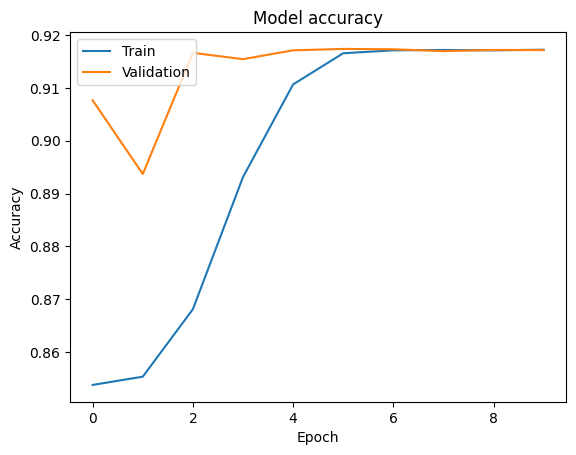

In [31]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])  # Ensure 'accuracy' is the right key; sometimes it could be 'acc'
plt.plot(history.history['val_accuracy'])  # Likewise, confirm if it should be 'val_accuracy' or 'val_acc'
plt.title('Model 3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Model_03_Accuracy.png')
plt.show()

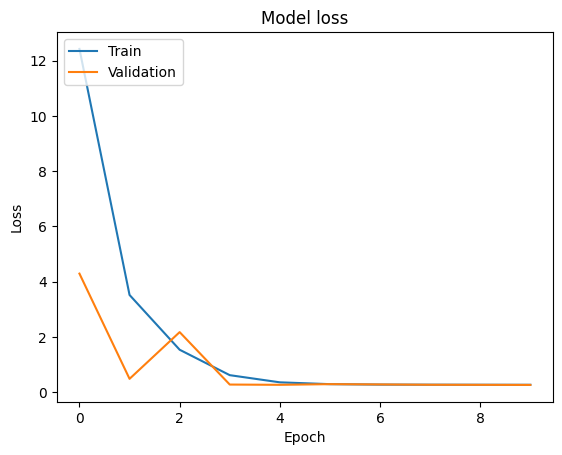

In [32]:
# Plot training & validation loss values
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])
plt.title('Model 3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Model_03_Loss.png')
plt.show()


1422/1422 [==============================] - 1s 438us/step


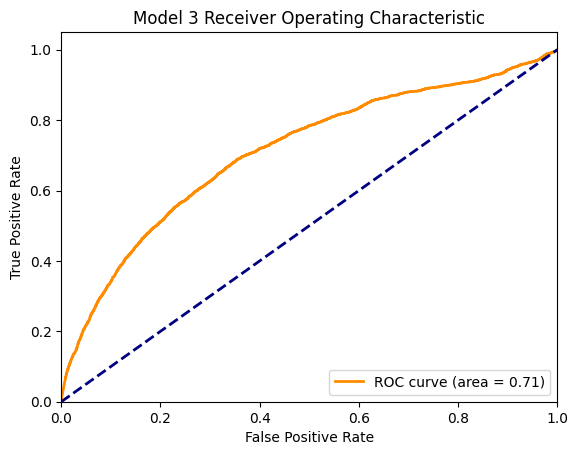

In [35]:
# Assume your model's prediction probabilities for the positive class are stored in y_scores
y_scores = diso_model.predict(X_test)

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model 3 Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Model_03_ROC.png')
plt.show()


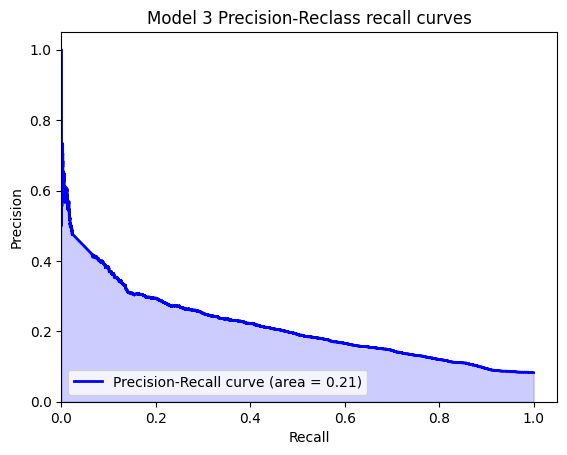

In [36]:
# Compute Precision-Recall and plot curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Model 3 Precision-Reclass recall curves')
plt.legend(loc="lower left")
plt.savefig('Model_03_recall.png')
plt.show()


### RBS Only Model

In [18]:
# Assuming df_expanded is your final DataFrame after preprocessing
rbs_features = DSSP_rbs_only_df.drop(['binding_ground_truth', 'ID', 'Unnamed: 0'], axis=1)  # ID is also not a feature
rbs_labels = DSSP_rbs_only_df['binding_ground_truth']

# Convert DataFrame to numpy arrays
rbs_X = rbs_features.values
rbs_y = rbs_labels.values

# Reshape X to fit the CNN input shape (batch_size, height, width, channels)
# For 1D sequence data, you could treat each feature as a channel:
rbs_X = rbs_X.reshape((rbs_X.shape[0], 1, rbs_X.shape[1], 1))  # Height = 1, Width = number of features, Channels = 1

In [19]:
rbs_X_train, rbs_X_test, rbs_y_train, rbs_y_test = train_test_split(rbs_X, rbs_y, test_size=0.3, random_state=42)

In [20]:
rbs_model = Sequential([
    Conv2D(32, (1, 3), activation='relu', input_shape=(1, rbs_X_train.shape[2], 1)),  # Adjust the input shape and kernel
    MaxPooling2D(pool_size=(1, 2)),
    Flatten(),  # Flatten converts the 3D output to 1D for input to the fully connected layers
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

rbs_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Now, let's check the model summary to understand its architecture
rbs_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 23, 32)         128       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 11, 32)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 352)               0         
                                                                 
 dense (Dense)               (None, 64)                22592     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 22,785
Trainable params: 22,785
Non-trainable params: 0
____________________________________________________

2024-08-11 17:52:14.809496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-11 17:52:14.817493: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-11 17:52:14.817529: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-08-11 17:52:14.817559: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-08-11 17:52:14.817591: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [21]:
rbs_history = rbs_model.fit(rbs_X_train, rbs_y_train, epochs=10, validation_data=(rbs_X_test, rbs_y_test), batch_size=32)

Epoch 1/10
1779/1779 [==============================] - 3s 1ms/step - loss: 0.3527 - accuracy: 0.8758 - val_loss: 0.3454 - val_accuracy: 0.8784
Epoch 2/10
1779/1779 [==============================] - 2s 1ms/step - loss: 0.3442 - accuracy: 0.8770 - val_loss: 0.3437 - val_accuracy: 0.8784
Epoch 3/10
1779/1779 [==============================] - 2s 1ms/step - loss: 0.3428 - accuracy: 0.8770 - val_loss: 0.3432 - val_accuracy: 0.8784
Epoch 4/10
1779/1779 [==============================] - 2s 1ms/step - loss: 0.3423 - accuracy: 0.8770 - val_loss: 0.3450 - val_accuracy: 0.8784
Epoch 5/10
1779/1779 [==============================] - 2s 1ms/step - loss: 0.3414 - accuracy: 0.8770 - val_loss: 0.3419 - val_accuracy: 0.8784
Epoch 6/10
1779/1779 [==============================] - 2s 1ms/step - loss: 0.3409 - accuracy: 0.8770 - val_loss: 0.3431 - val_accuracy: 0.8784
Epoch 7/10
1779/1779 [==============================] - 2s 1ms/step - loss: 0.3408 - accuracy: 0.8770 - val_loss: 0.3416 - val_accuracy:

763/763 [==============================] - 0s 431us/step


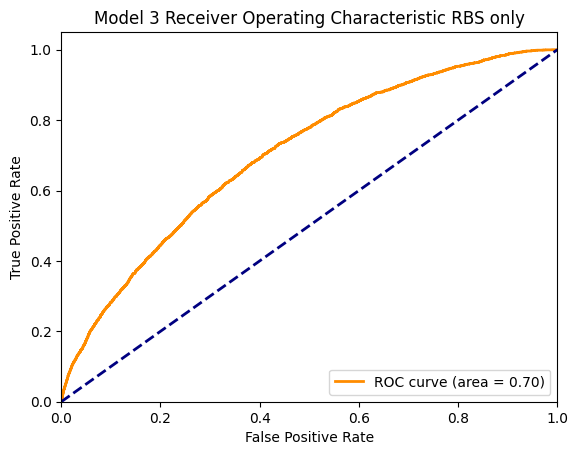

In [22]:
# Assume your model's prediction probabilities for the positive class are stored in y_scores
rbs_y_scores = rbs_model.predict(rbs_X_test)

# Compute ROC Curve
fpr, tpr, _ = roc_curve(rbs_y_test, rbs_y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model 3 Receiver Operating Characteristic RBS only')
plt.legend(loc="lower right")
plt.savefig('Model_03_ROC_rbs.png')
plt.show()


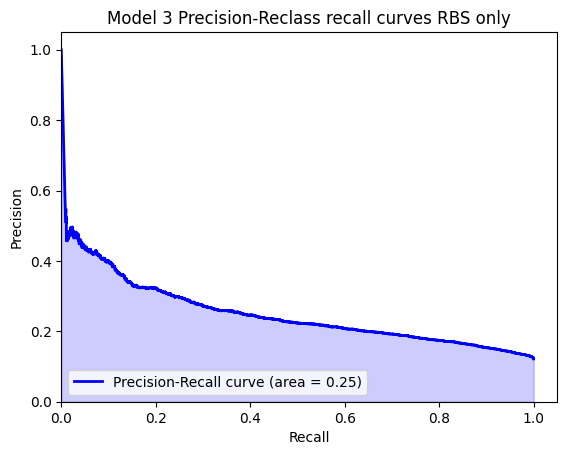

In [23]:
# Compute Precision-Recall and plot curve
precision, recall, thresholds = precision_recall_curve(rbs_y_test, rbs_y_scores)
average_precision = average_precision_score(rbs_y_test, rbs_y_scores)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Model 3 Precision-Reclass recall curves RBS only')
plt.legend(loc="lower left")
plt.savefig('Model_03_recall_rbs.png')
plt.show()
